# Sentiment Analysis with Deep Learning

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.models import load_model
import tensorflow as tf

tf.random.set_seed(42)

Loading training / validation set (preprocessed):

In [24]:
batch_size = 1024
seed = 42
train_ds = tf.keras.utils.text_dataset_from_directory("./dataset/train/pre_final", batch_size=batch_size, validation_split=0.2, subset="training", seed=seed)
val_ds = tf.keras.utils.text_dataset_from_directory("./dataset/train/pre_final", batch_size=batch_size, validation_split=0.2, subset="validation", seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [25]:
print("Label 0: ", train_ds.class_names[0])
print("Label 1: ", val_ds.class_names[1])

Label 0:  neg
Label 1:  pos


Fetching some examples for testing implementation code:

In [26]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(5):
        print(label_batch[i].numpy(), text_batch.numpy()[i])

1 b'first see twelve year ago little money entertainment rent fianc watch bone chill winter night want go rent instead not expect much much surprised good recently watch again love every bit much first time unfamiliar scottish outlaw cattleman folk hero little know man liberty take fact not textbook filmmaker excuse basically plot borrow money marquis montrose buy cattle intend sell reap large profit plan foil friend entrust money rob cash murder forest hero find run fail settle matter wife suffer sadistic rape hand archibald cunningham smarmy englishman no soul atrocity ensue immensely satisfying conclusion carve archibald like christmas turkey many great performance allow touch specifically usual fantastic sexy beast not take eye honestly man like ice cream even bad good honourable man struggle provide depend good way know give woman fierceness nice change simpering dull wife audience usually force endure know not take anyone else matter completely top portrayal evil yet somehow work

Optimize tf:

In [27]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Build the Model

In [28]:
vocab_size = 15000 
sequence_length = 500
embedding_dim = 8 

Input Layer:

In [29]:
vectorize_layer = TextVectorization(
    standardize = None, 
    max_tokens = vocab_size, 
    ngrams = (1,2),  
    output_mode = "int", 
    output_sequence_length = sequence_length
)

Map and adapt to build the vocabulary:

In [30]:
text_ds = train_ds.map(lambda x, y:x)
vectorize_layer.adapt(text_ds)

Build the architecture:

In [31]:
model = Sequential([
    vectorize_layer, 
    Embedding(vocab_size, embedding_dim, name="embedding"), 
    GlobalAveragePooling1D(),    
    Dense(16, activation="relu"), 
    Dense(1)
])

Optimizing training process and plot graphics to tensorboard:

In [32]:
import datetime 
log_dir = "./logs" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "final"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
tensorboard_callback_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=15
)

Compile the model:

In [34]:
model.compile(optimizer="adam", 
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics = ["accuracy"])

And finally fit it: 

In [13]:
model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 100, 
    callbacks=[tensorboard_callback, tensorboard_callback_early_stopping]
)

Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 206ms/step - accuracy: 0.9401 - loss: 0.1670 - val_accuracy: 0.8758 - val_loss: 0.2793
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.9409 - loss: 0.1653 - val_accuracy: 0.8758 - val_loss: 0.2794
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - accuracy: 0.9416 - loss: 0.1635 - val_accuracy: 0.8756 - val_loss: 0.2796
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.9424 - loss: 0.1618 - val_accuracy: 0.8754 - val_loss: 0.2799
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9424 - loss: 0.1601 - val_accuracy: 0.8756 - val_loss: 0.2801
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.9429 - loss: 0.1585 - val_accuracy: 0.8758 - val_loss: 0.2804
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 200ms/step - accuracy: 0.9437 - loss: 0.1569 - val_accuracy: 0.8752 - val_loss: 0.2806
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 201ms/step - accuracy: 0.9442 - loss: 0.1552 - val_accu

Show model summary:

In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, 500)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 500, 8)              │         120,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 8)                   │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 360,485 (1.38 MB)

 Trainable params: 120,161 (469.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 240,324 (938.77 KB)

Save model:

In [18]:
model.save('./models/model_NN_final.keras')

In [19]:
weights = model.get_layer("embedding").get_weights()[0]
vocab = vectorize_layer.get_vocabulary()

In [20]:
import io 

out_v = io.open("./models/vectors_NN_final.tsv", "w", encoding="utf-8")
out_m = io.open("./models/metadata_NN_final.tsv", "w", encoding="utf-8")

for index, word in enumerate(vocab):
    if index == 0:
        continue  # skip 0, its padding

    else:
        vec = weights[index]
        out_v.write("\t".join([str(x) for x in vec]) + "\n")
        out_m.write(word + "\n")

out_v.close()
out_m.close() 

# Testing

Load preprocessed test set: 

In [9]:
test_ds = tf.keras.utils.text_dataset_from_directory("./dataset/test/pre_final")

Found 25000 files belonging to 2 classes.


Evaluate model on test set:

In [10]:
results = model.evaluate(test_ds)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

NameError: name 'model' is not defined

# Use Model to predict own Examples:

Here you can enter own texts to predict their sentiment: 

In [31]:
examples = [ #neg, neg, pos pos pos
"""Humm, an Italian movie starred by David hasselhoff and Linda Blair, I wasn´t expecting very much, to be honest and in fact, I took even less than I was expecting. It doesn´t mean this movie is the worst I have seen because I have watched worse things than this but the plot was most of the times confusing and uninteresting and some good gore scenes are the only thing saving this. Apart from that you are going to love some special effects, they are really cheesy and bad. Now I only want to watch "Troll 3" by this same director, sure it is not going to be worse than that.""",
"""It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Damme as you can see he tried his best, but let's face it, he's almost fifty, how much more can you ask of him? I find it so hard to believe that the same people who put together Undisputed 2; arguably the best (western) martial arts movie in years, created this. Everything from the plot, to the dialog, to the editing, to the overall acting was just horribly put together and in many cases outright boring and nonsensical. Scott Adkins who's fight scenes seemed more like a demo reel, was also terribly underused and not even the main villain which is such a shame because 1) He is more than capable of playing that role and 2) The actual main villain was not only not intimidating at all but also quite annoying. Again, not blaming Van Damme. I will always be a fan, but avoid this one.""",
"""I watch Lackawanna Blues every time it comes on. It brings back happy times for me. I grow up in a big city in the mid-west. It reminds me of when I was a child although my situation was a little different it feels the same. It makes me wonder if all we will ever know about families are lost. The big mama's of day are under the age of 55. Will they see know what it takes to be a inspiration to other. I hope that I was not the only one who loved this movie enough to relate it to their past. The music was great in this movie. I truly felt like this should have gone to the theaters I would have paid to see it. As I viewed the movie for the second time I figured out who life this movie was about. He did an superb job in writing and producing this film. I guess who better to produce a film based on your life other than you. As soon as I can I will be obtaining a copy for my home use. I alway enjoy black producer or directors they make such film feel like you were actually living in the time right than. Thanks for such a great movie.""",
"""Jacqueline Hyde is a good quality film and does manage to be likable because of what it is. Everyone out there will like it! Sandwiched between the amount of breast shots, the times Jacqueline rubs herself, the various times Jackie spends chatting to herself and the times spent heaving in the Magdelena Mountains, this could create one hell of a dishwasher if your career were to end.<br /><br />Unlike most horror movies that take place in space or in some restless tranquility with ripe green apples, this one takes awhile to guzzle. The performing is good. Other than great acting by Dan the pizza delivery guy (must see), there are no standouts, but no notably bad outcroppings from my recent dinner either (and I do mean recent). Excellent acting overall because there are no typically dreadful actors which you'd find in movies of the four "Skin" related data fields or in the biological skimmer's found in any IBM shop. In addition if you see a female in this movie, the likelihood is that she will be butt naked by the next scene! Now that I think about it, there is quite a bit of action in this movie. Between the first and the second electro yank obtained from a hot chick and the time you observe her "buckets naked", keeps em' speculating. I loved it!""", 
"""1 b'first saw twelve year ago little money entertainment rented fianc watch bone chilling winter night wanted gone rented instead not expecting much much surprised good recently watched again loved every bit much first time unfamiliar scottish outlaw cattleman folk hero little know man liberty taken fact not textbook filmmaker excused basically plot borrows money marquis montrose buy cattle intends sell reap large profit plan foiled friend entrusted money robbed cash murdered forest hero find run failing settle matter wife suffers sadistic rape hand archibald cunningham smarmy englishman no soul atrocity ensue immensely satisfying conclusion carves archibald like christmas turkey many great performance allow touch specifically usual fantastic sexy beast ca take eye honestly man like ice cream even bad good honourable man struggling provide depend best way know give woman fierceness nice change simpering dull wife audience usually forced endure know take anyone else matter completely top portrayal evil yet somehow work posturing preening combined wicked dialogue result memorable villain recent memory combine stellar work supporting player luscious scenery scotland amount cool seen highly recommend '
"""
]

Preprocessing the input:

In [32]:
import spacy
nlp = spacy.load("en_core_web_sm")
import re 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))
stop_words.remove("not")
stop_words.remove("nor")
stop_words.remove("no")
stop_words.remove("again")
add_stopwords  = set(["movie", "film", "one", "the", "scene", "this", "story", "would", "really", "and", "also", ])
stop_words = stop_words.union(add_stopwords)

def remove_html(text):
    text = re.sub(r"<[\w]+ />", " ", text)
    text = re.sub("n't", " not", text)
    return text 

def clean_text(text):
    text = text.lower()
    text = re.sub(r"\b\w{1,1}\b", " ", text)                                                     # remove single characters
    text = re.sub(r"[^a-z]", " ", text)                                                          # remove everything which aren't letters
    text = re.sub(r"[\s]+", " ", text)                                                           # remove too many whitespaces
    return text

def process_and_filter_non_entities(text):
    doc = nlp(text)
    non_entity_lemmas = [token.lemma_ for token in doc if token.ent_type_ != "PERSON"]
    non_entity_lemmas = [token for token in non_entity_lemmas if token.lower() not in stop_words]
    text = " ".join(non_entity_lemmas) 
    return text

Predict own data:

In [40]:
def predict_new_data(text_sample):
    for t in text_sample:
        text_removed_html = remove_html(t)
        text_removed_ents = process_and_filter_non_entities(text_removed_html)
        processed_content = clean_text(text_removed_ents)

        # Ensure it's a tensor
        pred = model.predict(tf.constant([processed_content]), verbose=0)

        # Apply sigmoid and convert to Python float
        prob = tf.nn.sigmoid(pred[0]).numpy().item()

        # Print short preview + sentiment
        preview = text_removed_html[:120] + "..."
        if prob > 0.5:
            print(f"{preview}\n→ Positive :) (score={prob:.4f})\n")
        else:
            print(f"{preview}\n→ Negative :( (score={prob:.4f})\n")



predict_new_data(examples)


Humm, an Italian movie starred by David hasselhoff and Linda Blair, I wasn´t expecting very much, to be honest and in fa...
→ Negative :( (score=0.0024)

It actually pains me to say it, but this movie was horrible on every level. The blame does not lie entirely with Van Dam...
→ Negative :( (score=0.0033)

I watch Lackawanna Blues every time it comes on. It brings back happy times for me. I grow up in a big city in the mid-w...
→ Positive :) (score=0.9950)

Jacqueline Hyde is a good quality film and does manage to be likable because of what it is. Everyone out there will like...
→ Positive :) (score=0.9423)

1 b'first saw twelve year ago little money entertainment rented fianc watch bone chilling winter night wanted gone rente...
→ Positive :) (score=0.9755)



# Test manually to plot confusion matrix:

In [41]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [54]:
test_csv = "./dataset/testing_set_preprocessed.csv"
data = pd.read_csv(test_csv)
data

,review,sentiment
0,go see last night coax friend mine admit reluc...,pos
1,actor turn director follow promising debut got...,pos
2,recreational golfer knowledge sport history pl...,pos
3,see sneak preview delightful cinematography un...,pos
4,take true us golf open make much extra ordinar...,pos
...,...,...
24995,occasionally let kid watch garbage understand ...,neg
24996,anymore pretty much reality tv show people mak...,neg
24997,basic genre thriller intercut uncomfortable me...,neg
24998,four thing intrigue firstly star carly pope po...,neg


In [ ]:
# Map true labels to integers
y_true = [1 if lbl == "pos" else 0 for lbl in data["sentiment"]]

In [ ]:
# Predict labels using the trained model
y_pred = []
for i, text in enumerate(data["review"]):
    pred_logits = model.predict(tf.constant([text]), verbose=0)
    prob = tf.nn.sigmoid(pred_logits[0]).numpy().item()
    y_pred.append(1 if prob > 0.5 else 0)


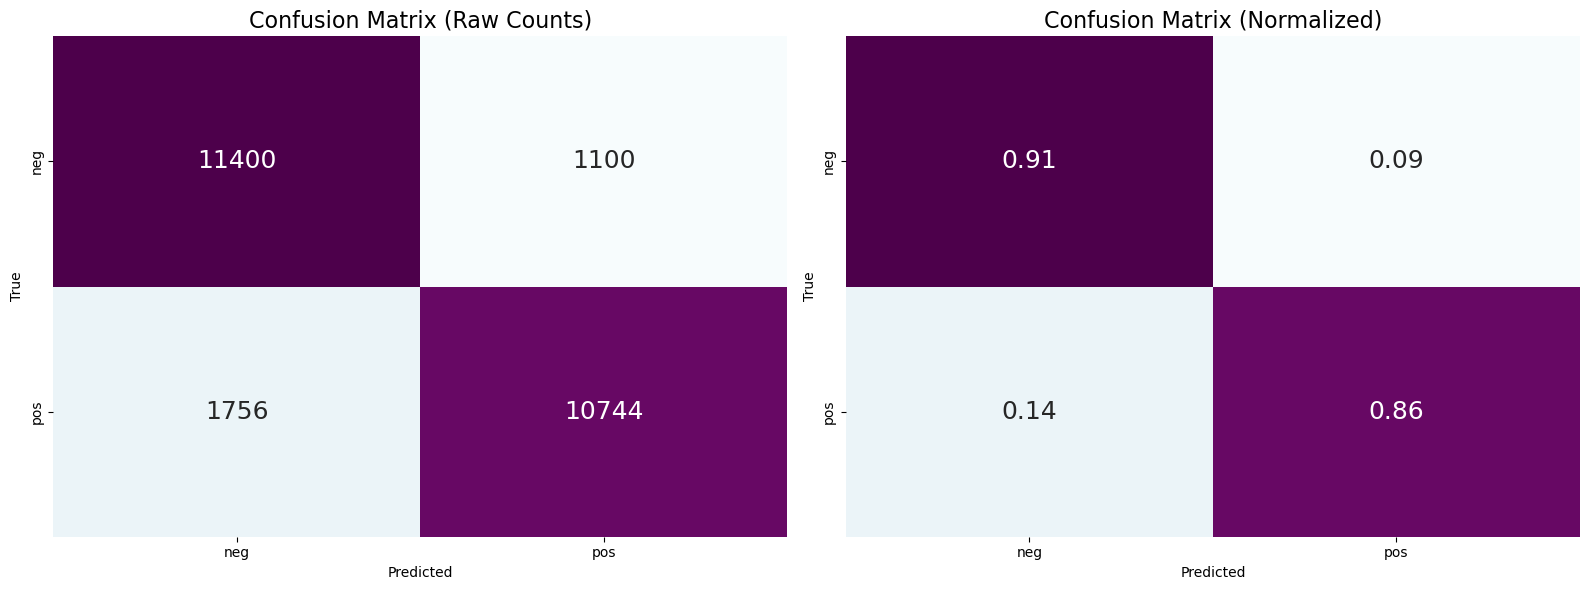

In [56]:
# Confusion matrices
conf_mtx = confusion_matrix(y_true, y_pred)
conf_mtx_norm = confusion_matrix(y_true, y_pred, normalize="true")

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
sns.heatmap(conf_mtx, annot=True, fmt='g', cmap='BuPu', xticklabels=['neg','pos'], yticklabels=['neg','pos'], ax=axs[0], cbar=False, annot_kws={"size":18})
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")
axs[0].set_title("Confusion Matrix (Raw Counts)", fontsize=16)

# Normalized
sns.heatmap(conf_mtx_norm, annot=True, fmt=".2f", cmap='BuPu', xticklabels=['neg','pos'], yticklabels=['neg','pos'], ax=axs[1], cbar=False, annot_kws={"size":18})
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")
axs[1].set_title("Confusion Matrix (Normalized)", fontsize=16)

plt.tight_layout()
plt.show()

In [57]:
# Compute metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8858
Precision: 0.9071
Recall: 0.8595
F1-score: 0.8827
